# Using sound symbolic patterns in a text classifer

### Task
* Predict the genre of a movie based on its title.
* Intuition: it's possible — humans can do it!
* Initial setup:
   * Classes — serious horror vs. romantic comedy
   * ~5,300 movie titles from The Movie Database
        * ~3,000 horror
        * ~2,300 romcom

### The problem
* Titles are very short documents (1-5 words)
* Many words only occur once in a data set
    * 'The Fortunes and Misfortunes of Moll Flanders'
    * 'The Incredible Jessica James'
    * 'The Burkittsville seven'
    
### Idea for a solution
* Sound symbolism — across languages, certain sounds tend to be associated with certain emotional/physical characteristics.
    * The 'bouba - kiki' effect — one word is spikey, one word is an amorphous blob.
    * https://en.wikipedia.org/wiki/Bouba/kiki_effect
* Vowels: words with 'eee' vs. words with 'aah':
    * eee: smaller, faster, lighter, and more pleasant.
    * aah: bigger, heavier, and more aggressive.
* Big idea: use vowel sounds to improve classification.
    * Every word has vowels: extract predictive information for out of vocabulary words.
    * Generalize across vowels using phonetic properties of vowel (e.g. high vowels; back vowels).

### Potential applications
* This could be useful for low resource languages, small datasets, or datasets that exhibit a lot creative word usage.
   * Learn patterns with fewer words.
   * If associations are universal, model of English could be transferred to another language
* Better branding.
    * Make your title (or product name) fit your genre (or product) better.
* Broader uses in sentiment and topic analysis.
    * Especially if sound symbolism extends to the emotional domain, as some research has suggested.

### Current models and results
* Finding: There's a very small but very consistent difference between horror and romcom titles with respect to the vowels they contain, but this effect isn't big enough to improve classification in the models.
* Models — logistic regression with different feature sets.
    * Bag of words — a feature for every word.
    * Bag of vowels — a feature for every vowel.
    * Bag of phonetic properties — a feature for every phonetic property.
    * Mixed bag words and vowels.
    * Mixed bag words and phonetic properties.
* Results — phonetic information doesn't improve classification.
    * Mixed bag models: overall, only marginally better than a bag of words model.
    * A preliminary model with consonants added looks best.
    * Bag of vowels / bag of properties models: only marginally better than a baseline model that always guesses horror.
* Future directions:
    * The main usefulness of this approach is for out of vocabulary words, where sound could serve as a fallback. Of course, the main determiner to word choice in titles is the meaning of the word.
    * The next step is to add:
        * Semantics.
            * Allows greater generalization across the small number of words.
        * Consonants and consonant features.
            * Some behavioral experiments have shown that the effects of consonants and vowels are additive, and the strongest effects occur when the two factors are congruent.
    * I also a Chinese data set - same set of movies written in Chinese -- to evaluate whether these effects hold across languages.
    

### Importing data set

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from g2p_en import G2p
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score, f1_score, 
                             plot_confusion_matrix, plot_roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB

# Read in the dataset, which comes from TMDB.

movies = pd.read_csv('movies_metadata.csv', dtype='string')
movies.dropna(subset = ['title', 'imdb_id', 'genres', 'popularity'], inplace=True)
movies = movies[(movies.genres != '[]') &
                (movies.title != '[]') &
                (movies.imdb_id != '[]') &
                (movies.original_language == 'en')]

# Add a column with labels for romcom and horror.

bool_is_romance = movies.genres.str.contains('Romance')
bool_is_comedy = movies.genres.str.contains('Comedy')
bool_is_horror = movies.genres.str.contains('Horror')
bool_is_serious_horror = (bool_is_comedy == False) & (bool_is_horror)
bool_is_rom_com = (bool_is_romance) & (bool_is_comedy)
movies['label'] = 'other'
movies.loc[bool_is_serious_horror, 'label'] = 'horror'
movies.loc[bool_is_rom_com, 'label'] = 'romcom'

# Dataframe for everything (df): just the romcoms and horror movies.
# The column 'imbd_id column' makes it easy to join with other data.
# 'Popularity' is a metric from TMDB that isn't well-defined, but maybe useful.

df = movies[movies.label != 'other']
keep_columns = ['title', 'label', 'imdb_id', 'popularity']
df = df[keep_columns]
df.reset_index(drop=True, inplace=True)
df['popularity'] = pd.to_numeric(df.popularity)
df.drop_duplicates(subset='title', inplace=True)

df.head()

,title,label,imdb_id,popularity
0,Grumpier Old Men,romcom,tt0113228,11.712900
1,Waiting to Exhale,romcom,tt0114885,3.859495
2,Sabrina,romcom,tt0114319,6.677277
3,The American President,romcom,tt0112346,6.318445
4,It Takes Two,romcom,tt0113442,7.777735


### Processing titles: adding transcriptions and phonetic properties

In [2]:
# Clean up titles.

title_processed = df.title.str.lower().str.strip()

# Remove sequels by looking for numbers and 'part'.

title_processed[(title_processed.str.contains(" part "))] = ''
title_processed[(title_processed.str.contains("[0-9]"))] = ''

re_roman_numerals = re.compile(' (x[cl]|l?x{0,3})(i[xv]|v?i{0,3})([:]|$)')
title_processed = title_processed.str.replace(re_roman_numerals, '')
title_processed = title_processed.str.replace('[&]', 'and')
title_processed = title_processed.str.replace('dr[.]', 'doctor')
title_processed = title_processed.str.replace('[:–-]', ' ')

def trim_ws(text):
    return re.sub('( )+', ' ', text).strip()
    
title_processed = title_processed.apply(trim_ws)

title_processed.head()

0          grumpier old men
1         waiting to exhale
2                   sabrina
3    the american president
4              it takes two
Name: title, dtype: object

In [3]:
# Add IPA transcriptions using g2p_en and then remove stopwords.

g2p = G2p()

ipa_split_by_word = []
titles_split_by_word = []

for title in title_processed:
    transcription = ' '.join(g2p(title))
    transcription = transcription.split('   ') 
    ipa_split_by_word.append(transcription)
    title_list = title.split(' ')
    titles_split_by_word.append(title_list)

# Remove stopwords from both IPA transcriptions and titles.
# This requires finding the stopword in the title and removing the corresponding
# word from the transcription. This happens after transcription, because transcription
# uses stopwords to help figure out contexts for PoS.

words_to_drop = stopwords.words('english')
for title_i in range(0, len(titles_split_by_word)):
    for word_i in range(0, len(titles_split_by_word[title_i])):
        if titles_split_by_word[title_i][word_i] in words_to_drop:
            titles_split_by_word[title_i][word_i] = ''
            ipa_split_by_word[title_i][word_i] = ''


# New columns for processed title and ipa, with stopwords and punctuation removed.

df['title_processed'] = [' '.join(x) for x in titles_split_by_word if x is not '']
df['ipa'] = [' '.join(x) for x in ipa_split_by_word if x != '']

re_punct = re.compile('[!"#$%()*+,-./:;<=>?@^\[\]\_\'`{|}~]')
df['title_processed'] = df.title_processed.str.replace(re_punct, '')
df['ipa'] = df.ipa.replace(re_punct, '')

df['title_processed'] = df.title_processed.apply(trim_ws)
df['ipa'] = df.ipa.apply(trim_ws)

# Lemmatize what's left.

lemmatizer = WordNetLemmatizer()

titles_stemmed = []
for title in df.title_processed:
    stemmed_words = [lemmatizer.lemmatize(word) for word in title.split(' ')]
    titles_stemmed.append(' '.join(stemmed_words))
df['title_stemmed'] = titles_stemmed

# Drop titles that were destroyed by stopword removal

df = df[df.title_processed != '']
df.reset_index(drop=True, inplace=True)

df[['title', 'title_processed', 'title_stemmed', 'ipa']].head(10)

,title,title_processed,title_stemmed,ipa
0,Grumpier Old Men,grumpier old men,grumpier old men,G R AH1 M P IY0 ER0 OW1 L D M EH1 N
1,Waiting to Exhale,waiting exhale,waiting exhale,W EY1 T IH0 NG EH0 K S HH EY1 L
2,Sabrina,sabrina,sabrina,S AH0 B R IY1 N AH0
3,The American President,american president,american president,AH0 M EH1 R AH0 K AH0 N P R EH1 Z AH0 D EH2 N T
4,It Takes Two,takes two,take two,T EY1 K S T UW1
5,Clueless,clueless,clueless,K L UW1 L AH0 S
6,Mighty Aphrodite,mighty aphrodite,mighty aphrodite,M AY1 T IY0 AE2 F R AH0 D AY1 T IY0
7,Home for the Holidays,home holidays,home holiday,HH OW1 M HH AA1 L AH0 D EY2 Z
8,Two If by Sea,two sea,two sea,T UW1 S IY1
9,From Dusk Till Dawn,dusk till dawn,dusk till dawn,D AH1 S K T IH1 L D AO1 N


In [4]:
# Extract just the stressed vowels as column 'vowels'.
# Unstressed vowels -- like stopwords -- are less informative.

df['vowels'] = df.ipa

re_consonants = re.compile('[A-Z]*(?=($|\s))')
re_unstressed_vowels = re.compile('.H0')
re_stress_markers = re.compile('[0-9]')

df['vowels'] = df.vowels.str.replace(re_consonants, '')
df['vowels'] = df.vowels.str.replace(re_unstressed_vowels, '')
df['vowels'] = df.vowels.str.replace(re_stress_markers, '')
df['vowels'] = df.vowels.apply(trim_ws)

# Merge 'AO' and 'AA' since most speakers have merged them in tge US.

df['vowels'] = df.vowels.str.replace('AO', 'AA')

# Extract consonants. (Not yet incorporated into model.)
# Single consonants need to be doubled because of the scikit learn vectorizer.

df['consonants'] = df.ipa
df['consonants'] = df.consonants.str.replace('[A-Z]*[0-9]', '')
df['consonants'] = df.consonants.apply(lambda x : re.sub('(?<!\w)([A-Z])(?!\w)', 
                                                         '\g<1>\g<1>', x))

df[['title', 'title_stemmed', 'ipa', 'vowels', 'consonants']].head(10)

,title,title_stemmed,ipa,vowels,consonants
0,Grumpier Old Men,grumpier old men,G R AH1 M P IY0 ER0 OW1 L D M EH1 N,AH IY ER OW EH,GG RR MM PP LL DD MM NN
1,Waiting to Exhale,waiting exhale,W EY1 T IH0 NG EH0 K S HH EY1 L,EY EY,WW TT NG KK SS HH LL
2,Sabrina,sabrina,S AH0 B R IY1 N AH0,IY,SS BB RR NN
3,The American President,american president,AH0 M EH1 R AH0 K AH0 N P R EH1 Z AH0 D EH2 N T,EH EH EH,MM RR KK NN PP RR ZZ DD NN TT
4,It Takes Two,take two,T EY1 K S T UW1,EY UW,TT KK SS TT
5,Clueless,clueless,K L UW1 L AH0 S,UW,KK LL LL SS
6,Mighty Aphrodite,mighty aphrodite,M AY1 T IY0 AE2 F R AH0 D AY1 T IY0,AY IY AE AY IY,MM TT FF RR DD TT
7,Home for the Holidays,home holiday,HH OW1 M HH AA1 L AH0 D EY2 Z,OW AA EY,HH MM HH LL DD ZZ
8,Two If by Sea,two sea,T UW1 S IY1,UW IY,TT SS
9,From Dusk Till Dawn,dusk till dawn,D AH1 S K T IH1 L D AO1 N,AH IH AA,DD SS KK TT LL DD NN


In [5]:
# Add phonetic properties for the vowels.
# Import phonetic property lookup table and rename columns to match data.

phon_props = pd.read_csv('HayesWhiteFeatures.txt', index_col=0, sep='\t')
new_names = [re.sub('1', '', index) for index in phon_props.index]
phon_props = phon_props.rename(index=dict(zip(phon_props.index, new_names)))

# Add a front feature to make annotation easier (usually 'front' is -back).

phon_props['front'] = phon_props.back.str.replace('+','0')
phon_props['front'] = phon_props.front.replace('-','+')

phon_props.tail(10)

,syllabic,diphthong,mainstress,stress,consonantal,sonorant,continuant,nasal,voice,LABIAL,...,strident,lateral,DORSAL,high,low,back,tense,rhotic,rhyme,front
OW,+,-,+,+,-,+,0,0,0,0,...,0,0,0,-,-,+,+,0,0,0
AA,+,-,+,+,-,+,0,0,0,0,...,0,0,0,-,+,+,+,0,0,0
AE,+,-,+,+,-,+,0,0,0,0,...,0,0,0,-,+,-,-,0,0,+
IH,+,-,+,+,-,+,0,0,0,0,...,0,0,0,+,-,-,-,0,0,+
UH,+,-,+,+,-,+,0,0,0,0,...,0,0,0,+,-,+,-,0,0,0
AW,+,+,+,+,-,+,0,0,0,0,...,0,0,0,+,-,+,+,0,0,0
AY,+,+,+,+,-,+,0,0,0,0,...,0,0,0,+,-,-,+,0,0,+
IY,+,-,+,+,-,+,0,0,0,0,...,0,0,0,+,-,-,+,0,0,+
OY,+,+,+,+,-,+,0,0,0,0,...,0,0,0,+,-,-,+,0,0,+
UW,+,-,+,+,-,+,0,0,0,0,...,0,0,0,+,-,+,+,0,0,0


In [6]:
# Using a lookup table, extract phonetic properties for vowels.
# TODO: replace this with average formant values from Ladefoged.

def get_phon_prop(transcription, prop, prop_set):
    if prop not in prop_set:
        print('Oops! "%s" is not in the phonetic set' % prop)
        return
    sounds_with_prop = list(prop_set[prop_set[prop] == '+'].index)
    output = []
    for sound in transcription.split():
        if sound in sounds_with_prop:
            output.append(prop)
    return ' '.join(output)

# PHONetic PROPertieS is the new column for extracted phonetic properties.

df['phon_props'] = ''

# Extract 'front', back', 'high', and 'low' features.

phon_properties_to_extract = ['front', 'high', 'back', 'low', 'tense', 'rhotic']

def get_phon_prop_lam(x,y): 
    return get_phon_prop(x, y, phon_props)

for phon_prop in phon_properties_to_extract:
    props_to_add = df.vowels.apply(get_phon_prop_lam, args=(phon_prop,))
    df['phon_props'] = df.phon_props + ' ' + props_to_add

df['phon_props'] = df.phon_props.apply(trim_ws)

df[['title', 'phon_props', 'vowels', 'title_stemmed']].head(10)

,title,phon_props,vowels,title_stemmed
0,Grumpier Old Men,front front high back back back tense tense te...,AH IY ER OW EH,grumpier old men
1,Waiting to Exhale,front front tense tense,EY EY,waiting exhale
2,Sabrina,front high tense,IY,sabrina
3,The American President,front front front,EH EH EH,american president
4,It Takes Two,front high back tense tense,EY UW,take two
5,Clueless,high back tense,UW,clueless
6,Mighty Aphrodite,front front front front front high high high h...,AY IY AE AY IY,mighty aphrodite
7,Home for the Holidays,front back back low tense tense tense,OW AA EY,home holiday
8,Two If by Sea,front high high back tense tense,UW IY,two sea
9,From Dusk Till Dawn,front high back back low tense,AH IH AA,dusk till dawn


### Data visualization: do romcoms have more high vowels?

In [7]:
# Calculate frequency of each vowel and property for each title.

counts_by_syllable = pd.DataFrame({'label': df.label})

vowel_list = ['IY', 'UW', 'IH', 'UH', 'EY', 'OW', 'EH', 'AE', 'AA']

for vowel in vowel_list:
    counts_by_syllable[vowel] = df.vowels.str.count(vowel)
    
prop_list = ['high', 'low', 'front', 'back', 'rhotic', 'tense']

for prop in prop_list:
    counts_by_syllable[prop] = df.phon_props.str.count(prop)

print(counts_by_syllable)

       label  IY  UW  IH  UH  EY  OW  EH  AE  AA  high  low  front  back  \
0     romcom   1   0   0   0   0   1   1   0   0     1    0      2     3   
1     romcom   0   0   0   0   2   0   0   0   0     0    0      2     0   
2     romcom   1   0   0   0   0   0   0   0   0     1    0      1     0   
3     romcom   0   0   0   0   0   0   3   0   0     0    0      3     0   
4     romcom   0   1   0   0   1   0   0   0   0     1    0      1     1   
...      ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   ...  ...    ...   ...   
5103  horror   0   0   0   0   0   0   0   0   1     1    1      1     1   
5104  romcom   1   0   0   0   0   0   0   0   1     1    1      1     1   
5105  horror   0   0   0   1   0   0   0   0   0     1    0      0     2   
5106  horror   0   0   0   0   0   0   0   0   1     1    1      0     3   
5107  horror   0   0   1   0   0   1   1   1   0     1    1      3     1   

      rhotic  tense  
0          1      3  
1          0      2  
2          0      1  

In [8]:
# Create a dataframe with counts for every vowel for easier plotting.

plot_sums = counts_by_syllable.groupby('label', as_index=False).sum()
plot_sums = plot_sums.melt(id_vars=['label'])

def count_words(text):
    return len(text.split(' '))

horror_total = df.loc[df.label == 'horror', 'vowels'].apply(count_words).sum()
rom_com_total = df.loc[df.label == 'romcom', 'vowels'].apply(count_words).sum()

plot_sums['total_vowels'] = 'nan'
plot_sums.loc[plot_sums.label == 'horror', 'total_vowels'] = horror_total
plot_sums.loc[plot_sums.label == 'romcom', 'total_vowels'] = rom_com_total
plot_sums['proportion_of_syllables'] = plot_sums.value/plot_sums.total_vowels

print(plot_sums)

     label variable  value total_vowels proportion_of_syllables
0   horror       IY    902         7473                0.120701
1   romcom       IY    893         6249                0.142903
2   horror       UW    256         7473               0.0342567
3   romcom       UW    314         6249                0.050248
4   horror       IH    599         7473               0.0801552
5   romcom       IH    584         6249                0.093455
6   horror       UH    103         7473                0.013783
7   romcom       UH     95         6249               0.0152024
8   horror       EY    528         7473               0.0706544
9   romcom       EY    478         6249               0.0764922
10  horror       OW    379         7473               0.0507159
11  romcom       OW    319         6249               0.0510482
12  horror       EH    863         7473                0.115482
13  romcom       EH    664         6249                0.106257
14  horror       AE    789         7473 

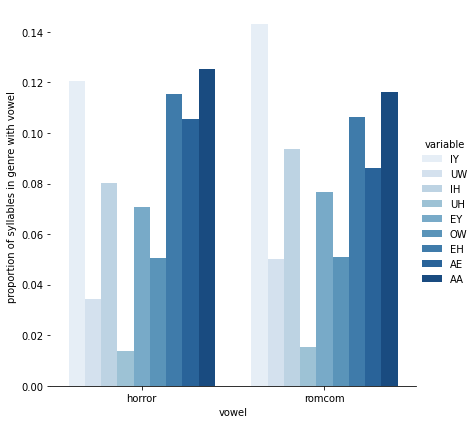

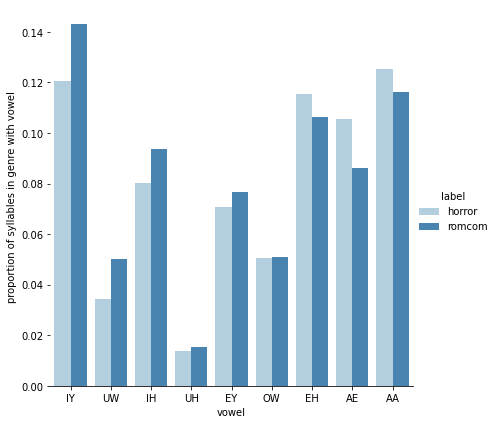

In [9]:
# Plot distribution of vowels for each genre.

bool_is_a_prop = plot_sums.variable.apply(
    lambda x : x in ['high', 'back', 'front', 'low', 'tense', 'rhotic'])

plot_just_vowels = plot_sums[~bool_is_a_prop]

g = sns.catplot(x ='label', y='proportion_of_syllables',
                hue='variable', data=plot_just_vowels, 
                height=6, kind='bar', palette='Blues')
g.despine(left=True)
g.set_ylabels('proportion of syllables in genre with vowel')
g.set_xlabels('vowel')

g = sns.catplot(x ='variable', y='proportion_of_syllables',
                hue='label', data=plot_just_vowels, 
                height=6, kind='bar', palette='Blues')
g.despine(left=True)
g.set_ylabels('proportion of syllables in genre with vowel')
g.set_xlabels('vowel')

In [10]:
# Question: What are the horror movies with 'eee'?
# Answer: really semantically loaded words, and some franchises.

# Sound symbolism will have the strongest effect (and be most useful)
# when there's freedom of choice -- strongest in novel coinages.
# TODO: look at hapaxes and see if effects are stronger.

df[(df.vowels.str.contains('IY')) & (df.label == 'horror')].title.head(20)

11                                 Screamers
12                               Mary Reilly
28                              The Prophecy
29                                   Species
30                              Castle Freak
39               Mary Shelley's Frankenstein
65                            Body Snatchers
92           Candyman: Farewell to the Flesh
98                                Diabolique
118    Halloween: The Curse of Michael Myers
164                                   Aliens
165                                    Alien
178                                   Alien³
179              Amityville: It's About Time
180                    Amityville: Dollhouse
181             Amityville: A New Generation
182            Amityville II: The Possession
183                    The Amityville Horror
184                     The Amityville Curse
187                              Audrey Rose
Name: title, dtype: string

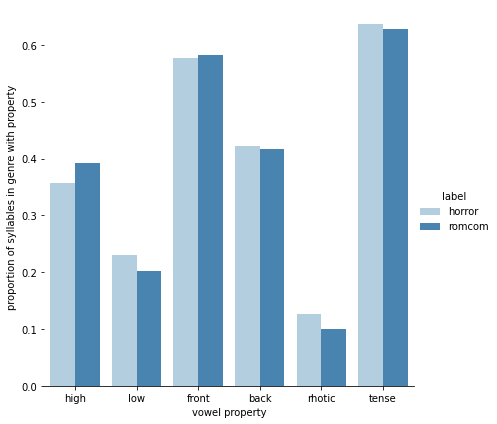

In [11]:
# Plot distribution of properties for each genre.

plot_just_props = plot_sums[bool_is_a_prop]

g = sns.catplot(x='variable', y='proportion_of_syllables', 
                hue='label', data=plot_just_props,
                height=6, kind='bar', palette='Blues')
g.despine(left=True)
g.set_ylabels('proportion of syllables in genre with property')
g.set_xlabels('vowel property')

In [12]:
# Instead of normalizing by number of syllables, normalize by number of words.
# Calculate frequency of words containing at least one instance of vowel or property

counts_by_word = pd.DataFrame({'label': df.label})

vowel_list = ['IY', 'UW', 'IH', 'UH', 'EY', 'OW', 'EH', 'AE', 'AA']
prop_list = ['high', 'low', 'front', 'back', 'rhotic', 'tense']

for vowel in vowel_list:
    counts_by_word[vowel] = df.vowels.str.contains(vowel)*1

for prop in prop_list:
    counts_by_word[prop] = df.phon_props.str.contains(prop)*1

plot_sums = counts_by_word.groupby('label', as_index=False).sum()
plot_sums = plot_sums.melt(id_vars=['label'])

horror_total = df.loc[df.label == 'horror', 'title_processed'].apply(count_words).sum()
rom_com_total = df.loc[df.label == 'romcom', 'title_processed'].apply(count_words).sum()

plot_sums['total_words'] = 'nan'
plot_sums.loc[plot_sums.label == 'horror', 'total_words'] = horror_total
plot_sums.loc[plot_sums.label == 'romcom', 'total_words'] = rom_com_total
plot_sums['value'] = pd.to_numeric(plot_sums.value)
plot_sums['total_words'] = pd.to_numeric(plot_sums.total_words)

plot_sums['proportion_of_words'] = (plot_sums.value/plot_sums.total_words)

print(plot_sums)


     label variable  value  total_words  proportion_of_words
0   horror       IY    801         5379             0.148912
1   romcom       IY    771         4601             0.167572
2   horror       UW    239         5379             0.044432
3   romcom       UW    293         4601             0.063682
4   horror       IH    562         5379             0.104480
5   romcom       IH    523         4601             0.113671
6   horror       UH    101         5379             0.018777
7   romcom       UH     92         4601             0.019996
8   horror       EY    494         5379             0.091839
9   romcom       EY    433         4601             0.094110
10  horror       OW    355         5379             0.065997
11  romcom       OW    284         4601             0.061726
12  horror       EH    762         5379             0.141662
13  romcom       EH    575         4601             0.124973
14  horror       AE    715         5379             0.132924
15  romcom       AE    4

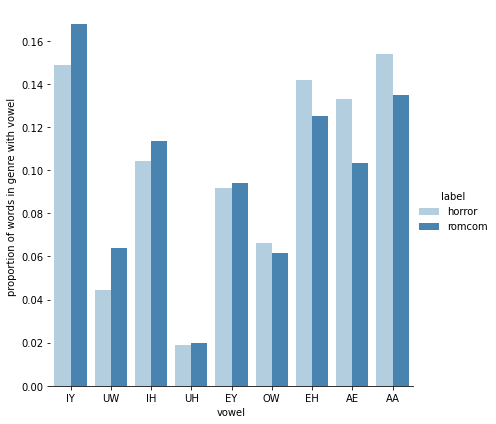

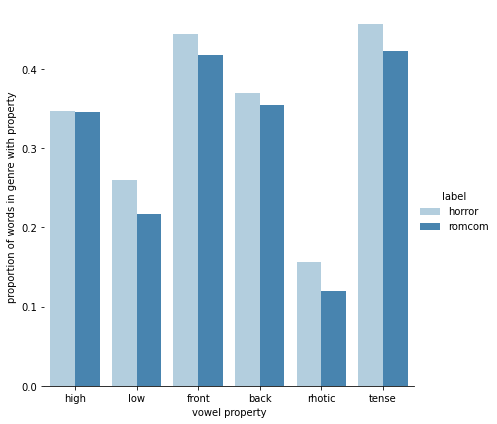

In [13]:
plot_just_vowels = plot_sums[~bool_is_a_prop]

g = sns.catplot(x ='variable', y='proportion_of_words',
                hue='label', data=plot_just_vowels,
                height=6, kind='bar', palette='Blues')
g.despine(left=True)
g.set_ylabels('proportion of words in genre with vowel')
g.set_xlabels('vowel')

plot_just_props = plot_sums[bool_is_a_prop]
g = sns.catplot(x='variable', y='proportion_of_words', 
                hue='label', data=plot_just_props,
                height=6, kind='bar', palette='Blues')
g.despine(left=True)
g.set_ylabels('proportion of words in genre with property')
g.set_xlabels('vowel property')

### Fitting and testing some classification models

In [14]:
# Create series with texts to be vectorized.
# Props and words = mixed bag of props and words.
# Vowels and words = mixed bag of vowels and words.

df['props_and_words'] = df.title_processed + ' ' + df.phon_props
df['vowels_and_words'] =  df.title_processed +  ' ' + df.vowels

# Encode the labels: 1 = romcom; 0 = horror.

le = preprocessing.LabelEncoder()
classes_encoded = le.fit_transform(df.label)

# Split data into train and test sets. Use indices for X since the
# features need to be fit independently for training and test data.
# (Since min_df = 2 in featurizer, and in case I add tf-idf.)

X = df.index.to_list()
y = classes_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
y_true = y_test

print('%s training items; %s testing items' % (len(X_train), len(X_test)))

3064 training items; 2044 testing items


In [15]:
# Eval model is a function that prints: classification report, 
# confusion matrix, ROC curve.

def eval_model(model, X_test, y_test, labels, model_name="model"):
    y_score = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=np.array(labels),
                                 cmap=plt.cm.Blues,
                                 normalize=None, values_format='G')
    title = ('Confusion matrix for %s'% model_name)
    disp.ax_.set_title(title)
    
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=np.array(labels),
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    title = ('Confusion matrix for %s'% model_name)
    disp.ax_.set_title(title)
    
    disp = plot_roc_curve(model, X_test, y_test)
    title = ('ROC curve for %s' % model_name)
    disp.ax_.set_title(title)

In [16]:
# Model 1: bag of words logistic regression.

vect_w = CountVectorizer(min_df = 2)
X_train_w = vect_w.fit_transform(df.title_stemmed.iloc[X_train])
X_test_w = vect_w.transform(df.title_stemmed.iloc[X_test])

print('Training items, number of features: ' + str(X_train_w.shape))
print('Sample training data:')
df.title_stemmed.head()

Training items, number of features: (3064, 895)
Sample training data:


0      grumpier old men
1        waiting exhale
2               sabrina
3    american president
4              take two
Name: title_stemmed, dtype: object

              precision    recall  f1-score   support

           0       0.68      0.89      0.77      1139
           1       0.77      0.46      0.58       905

    accuracy                           0.70      2044
   macro avg       0.73      0.68      0.67      2044
weighted avg       0.72      0.70      0.68      2044



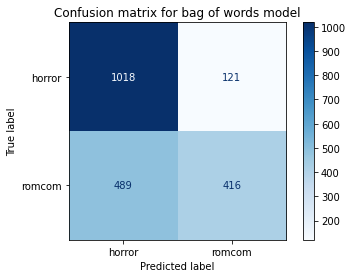

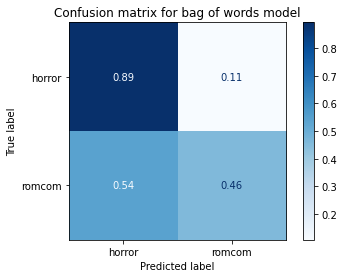

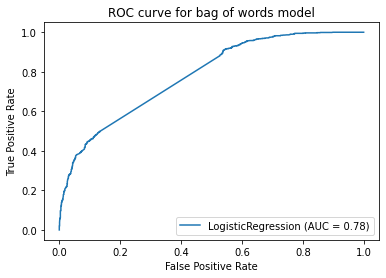

In [17]:
# Fit and evaluate a logistic regression on the test data.

mod_w = LogisticRegression()
mod_w.fit(X_train_w, y_train)

eval_model(mod_w, X_test_w, y_test, ['horror', 'romcom'], 
           'bag of words model')

# This model is much better at classifying horror than romance,
# at least given the default decision rule.

In [18]:
# Model 2: mixed bag of vowels + words

vect_vw = CountVectorizer(min_df = 2)
X_train_vw = vect_vw.fit_transform(df.vowels_and_words.iloc[X_train])
X_test_vw = vect_vw.transform(df.vowels_and_words.iloc[X_test])

print('Training items, number of features: ' + str(X_train_vw.shape))
print('Sample training data:')
df.vowels_and_words.head()

Training items, number of features: (3064, 917)
Sample training data:


0    grumpier old men AH IY ER OW EH
1               waiting exhale EY EY
2                         sabrina IY
3        american president EH EH EH
4                    takes two EY UW
Name: vowels_and_words, dtype: object

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1139
           1       0.71      0.53      0.61       905

    accuracy                           0.70      2044
   macro avg       0.70      0.68      0.68      2044
weighted avg       0.70      0.70      0.69      2044



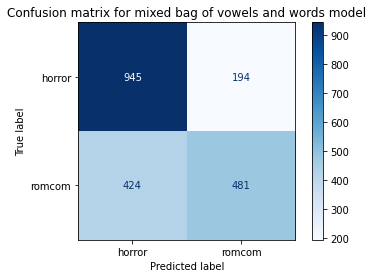

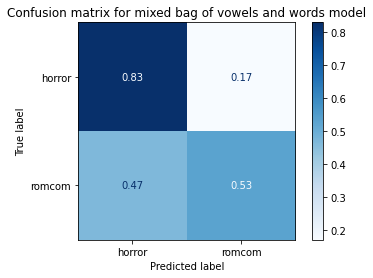

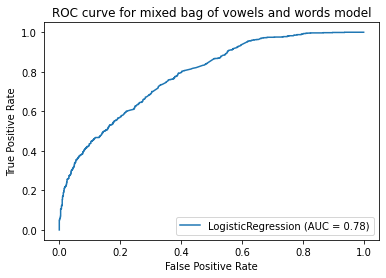

In [19]:
mod_vw = LogisticRegression()
mod_vw.fit(X_train_vw, y_train)

eval_model(mod_vw, X_test_vw, y_test, ['horror', 'romcom'], 
           'mixed bag of vowels and words model')

# Similar F1-score and AUC, but much better at romance than the 
# bag of words model.

In [20]:
# Model 3: mixed bag of props + words

vect_pw = CountVectorizer(min_df = 2)
X_train_pw = vect_pw.fit_transform(df.props_and_words.iloc[X_train])
X_test_pw = vect_pw.transform(df.props_and_words.iloc[X_test])

print('Training items, number of features: ' + str(X_train_pw.shape))
print('Sample training data:')
df.props_and_words.head()

Training items, number of features: (3064, 907)
Sample training data:


0    grumpier old men front front high back back ba...
1               waiting exhale front front tense tense
2                             sabrina front high tense
3                 american president front front front
4                takes two front high back tense tense
Name: props_and_words, dtype: object

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1139
           1       0.71      0.53      0.61       905

    accuracy                           0.70      2044
   macro avg       0.70      0.68      0.68      2044
weighted avg       0.70      0.70      0.69      2044



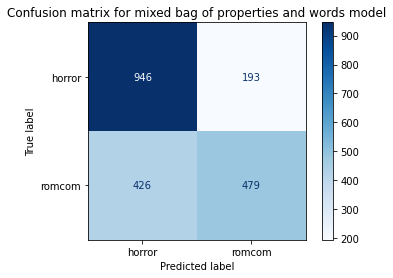

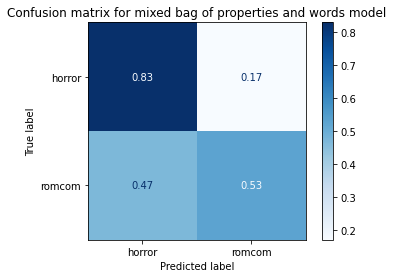

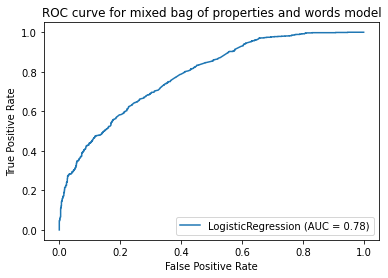

In [21]:
# Max iterations increased because the properties aren't scaled.
# The word features are mostly binary (1/0) for a document but the 
# property features can get much higher (6-7). Scaling sparse
# vectors seems like a bad idea, so the answer is probably to
# binarize.

mod_pw = LogisticRegression(max_iter = 200)
mod_pw.fit(X_train_pw, y_train)

eval_model(mod_pw, X_test_pw, y_test, ['horror', 'romcom'], 
           'mixed bag of properties and words model')

In [22]:
# Model 4: bag of vowels

vect_v = CountVectorizer(min_df = 2)
X_train_v = vect_v.fit_transform(df.vowels.iloc[X_train])
X_test_v = vect_v.transform(df.vowels.iloc[X_test])

                            
print('Training items, number of features: ' + str(X_train_v.shape))
print('Sample training data:')
df.vowels.head()

Training items, number of features: (3064, 14)
Sample training data:


0    AH IY ER OW EH
1             EY EY
2                IY
3          EH EH EH
4             EY UW
Name: vowels, dtype: object

              precision    recall  f1-score   support

           0       0.59      0.83      0.69      1139
           1       0.56      0.27      0.37       905

    accuracy                           0.58      2044
   macro avg       0.58      0.55      0.53      2044
weighted avg       0.58      0.58      0.55      2044



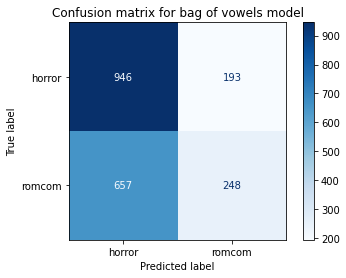

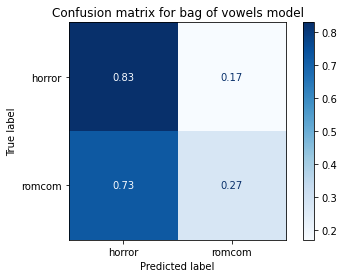

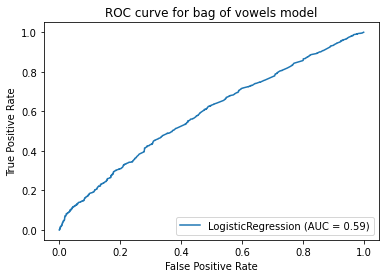

In [23]:
mod_v = LogisticRegression()
mod_v.fit(X_train_v, y_train)

eval_model(mod_v, X_test_v, y_test, ['horror', 'romcom'], 
           'bag of vowels model')

In [24]:
# Model 5: bag of phon props

vect_p = CountVectorizer(min_df = 2)
X_train_p = vect_p.fit_transform(df.phon_props.iloc[X_train])
X_test_p = vect_p.transform(df.phon_props.iloc[X_test])

print('Training items, number of features: ' + str(X_train_p.shape))
print('Sample training data:')
df.phon_props.head()

Training items, number of features: (3064, 6)
Sample training data:


0    front front high back back back tense tense te...
1                              front front tense tense
2                                     front high tense
3                                    front front front
4                          front high back tense tense
Name: phon_props, dtype: object

              precision    recall  f1-score   support

           0       0.58      0.89      0.71      1139
           1       0.59      0.19      0.29       905

    accuracy                           0.58      2044
   macro avg       0.59      0.54      0.50      2044
weighted avg       0.59      0.58      0.52      2044



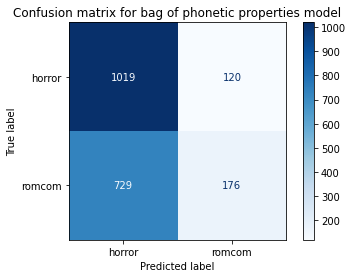

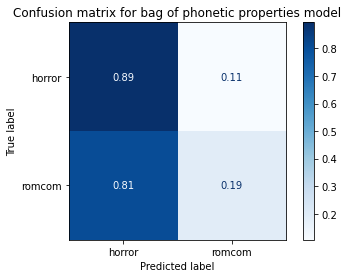

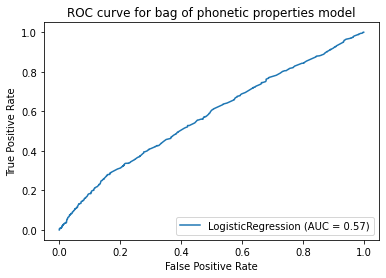

In [25]:
mod_p = LogisticRegression()
mod_p.fit(X_train_p, y_train)

eval_model(mod_p, X_test_p, y_test, ['horror', 'romcom'], 
           'bag of phonetic properties model')

In [26]:
# Model 6: trying out consonants

consonants_vowels = df.consonants + ' ' + df.vowels
consonants_vowels = consonants_vowels.apply(trim_ws)
consonants_vowels_words = consonants_vowels + ' ' + df.title_stemmed

vect_cv = CountVectorizer(min_df = 2)
X_train_cv = vect_cv.fit_transform(consonants_vowels.iloc[X_train])
X_test_cv = vect_cv.transform(consonants_vowels.iloc[X_test])

print('Training items, number of features: ' + str(X_train_p.shape))
print('Sample training data:')
consonants_vowels.head()

Training items, number of features: (3064, 6)
Sample training data:


0    GG RR MM PP LL DD MM NN AH IY ER OW EH
1                WW TT NG KK SS HH LL EY EY
2                            SS BB RR NN IY
3    MM RR KK NN PP RR ZZ DD NN TT EH EH EH
4                         TT KK SS TT EY UW
dtype: object

              precision    recall  f1-score   support

           0       0.61      0.79      0.69      1139
           1       0.58      0.37      0.45       905

    accuracy                           0.60      2044
   macro avg       0.60      0.58      0.57      2044
weighted avg       0.60      0.60      0.58      2044



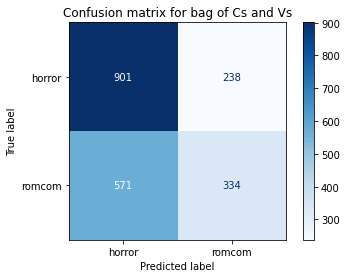

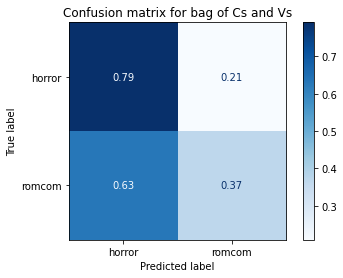

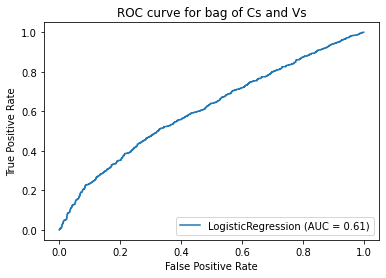

In [27]:
mod_cv = LogisticRegression()
mod_cv.fit(X_train_cv, y_train)

eval_model(mod_cv, X_test_cv, y_test, ['horror', 'romcom'], 
           'bag of Cs and Vs')

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1139
           1       0.72      0.58      0.64       905

    accuracy                           0.71      2044
   macro avg       0.72      0.70      0.70      2044
weighted avg       0.71      0.71      0.71      2044



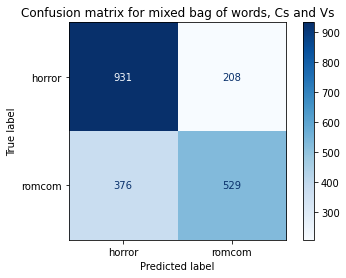

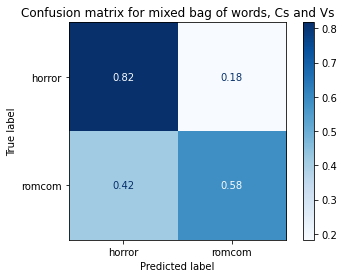

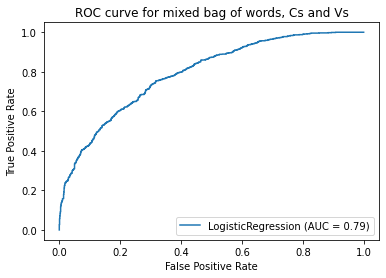

In [28]:
# Model 7: trying out consonants part 2

vect_cvw = CountVectorizer(min_df = 2)
X_train_cvw = vect_cvw.fit_transform(consonants_vowels_words.iloc[X_train])
X_test_cvw = vect_cvw.transform(consonants_vowels_words.iloc[X_test])

mod_cvw = LogisticRegression(max_iter = 200)
mod_cvw.fit(X_train_cvw, y_train)

eval_model(mod_cvw, X_test_cvw, y_test, ['horror', 'romcom'], 
           'mixed bag of words, Cs and Vs')

### Issues to address
* Automated transcriptions are not great
    * 976 evil = 'nine-hundred-seventy vust evil'
    * xtro = 'tea-strow'
* Many conflated meanings of sound symbolism
* Many conflated sub-genres in movies
* So far, assuming American English (not true)

### Ideas for further development
In descending order of complexity and importance
1. Consider the other genres (for example: drama)
    * Really it's multi-label classification
    * Simpler would be multi-class, but movie genres aren't exclusive bins
2. Add semantic features
    * Average all of the semantic vectors in a title
    * Use that to predict genre too
    * Same desirable properties as using phonetics
* Add consonants
    * DONE: superficially
    * Consonant features
        * Place of articulation
        * Voicing
* Phonetic properties should be continuous
    * How to featurize a word? That's tougher.
        * Average of vowels in word?
* Add morphemes / subparts of words
    * E.g. Clueless = clue + less
    * That helps!
* Add regularization
    * Ridge classifier? (1.1.2.2. Classification in sklearn docs)
* Other vectorizations of features
    * tf-idf
        * Tried -- doesn't help at all
        * Words are so infrequent that idf doesn't change anything
    * binary features?
        * Easier to interpret
* Lemmatize words
    * Done!
    * A smarter way that uses a PoS tagger would be better
* Read up on classification of very short documents
    * Names?
        * Ask Stephanie about names and gender classification
    * Tweets? Headlines?
    * Other simple classifiers
      * Naive Bayes
        * But features aren't independent
        * But are they ever?
        * Tried -- indistinguishable for these features
      * SVMs (multiclass SVM?)
      * Benefits of GLM
        * Easy to interpret
        * Each feature is assigned a score
        * Regularization is straightforward (L1, L2 prior)
* Look at types instead of token
    * Romance lexicon?
    * Horror lexicon?